# Multi-Label Movie Genre Prediction

The purpose of this project is to determine multiple labels for each movie by creating models with taking movie posters and their overviews as an input. Dataset is called ‘TMBD 5000 Movie Dataset’ and is extracted from ‘TMDB collection and includes 45466 movies with their informations of poster path, overview, original title, original language and release date

In [99]:
#Importing Libraries

import zipfile as zf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import ast
import urllib.request

#to ignore warning
import warnings
warnings.filterwarnings("ignore") 

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_fscore_support, hamming_loss,accuracy_score
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid
import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split


#importing nltk library
import nltk
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
import re

from collections import Counter
import squarify
import math


#to show all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

#tmdbv3api to download images
from tmdbv3api import TMDb
from tmdbv3api import Movie


#Importing tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import Constant
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import initializers, constraints, optimizers, layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, LSTM, SimpleRNN, Embedding, Dropout, SpatialDropout1D, Activation, Conv1D,GRU
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Add, Flatten
from sklearn.metrics import classification_report

In [2]:
#For extracting zip file and convert it to folder with the name "tmdb"

#files = zf.ZipFile("tmdb.zip", 'r')
#files.extractall('tmdb_data')
#files.close()

In [3]:
#For unzipping downloaded images

#images = zf.ZipFile("tmdb_data/images.zip", 'r')
#images.extractall('tmdb_data')
#images.close()

In [4]:
#Reading csv file
movies_metadata_df = pd.read_csv('tmdb_data/movies_metadata.csv')

In [5]:
#Filtering out columns

df_filtered = movies_metadata_df[['genres', 'id', 'original_language', 'original_title', 'poster_path',
                                 'release_date', 'overview']]

In [6]:
#Looking at top 5 rows of the filtered dataset

df_filtered.head(3)

genres  \
0   [{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, 'name': 'Fantasy'}, {'id': 10751, 'name': 'Family'}]   
2                                   [{'id': 10749, 'name': 'Romance'}, {'id': 35, 'name': 'Comedy'}]   

      id original_language    original_title  \
0    862                en         Toy Story   
1   8844                en           Jumanji   
2  15602                en  Grumpier Old Men   

                        poster_path release_date  \
0  /rhIRbceoE9lR4veEXuwCC2wARtG.jpg   1995-10-30   
1  /vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg   1995-12-15   
2  /6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg   1995-12-22   

                                                                                              overview  
0  Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear o...  
1  When siblings Judy and Peter discover an enchanted board game that opens the door to a magical w...  
2  A family wedding reignites the ancient feud between next-door neighbors and fishing buddies John...

In [7]:
#Extracting list from json_format in genres column 

genre_lst = []
for i in range(len(df_filtered['genres'])):
    genre_lst.append([])
               
for index, genre in enumerate(df_filtered['genres']): 
    results = ast.literal_eval(genre)
    for i in range(len(results)):
        genre_lst[index].append(results[i]['name'])

df_filtered['genres'] = genre_lst

In [8]:
#Removing genres that had only appeared ones
df_filtered['genres'] = df_filtered['genres'].apply(
    lambda row: [val for val in row if val not in ['Carousel Productions', 'Vision View Entertainment',
                                                   'Telescene Film Group Productions', 
                                                   'Aniplex', 'GoHands', 'BROSTA TV',
                                                   'Mardock Scramble Production Committee', 
                                                   'Sentai Filmworks','Odyssey Media', 
                                                   'Pulser Productions', 'Rogue State', 
                                                   'The Cartel', 'TV Movie']]
                                                    )

#Removing rows that do not have any genre
df_filtered = df_filtered[df_filtered['genres'].map(lambda row: len(row)) > 0]

#Removing rows that do not have an overview
df_filtered['overview'] = df_filtered['overview'].dropna()

df_filtered = df_filtered.reset_index(drop=True)

In [9]:
#Getting only english languaged films
df_filtered = df_filtered[df_filtered['original_language']=='en']

#Removing movies that was released before 1980
df_filtered['release_date'] = pd.to_datetime(df_filtered['release_date'])
df_filtered['release_year'] = df_filtered['release_date'].dt.year
df_filtered = df_filtered[df_filtered['release_year']>=1980]

In [10]:
#Looking at the duplicated values
print(f"Number of duplicated titles: {len(df_filtered['original_title'].duplicated())}")

#Getting the last released date of duplicated movies
df_filtered = df_filtered.sort_values('original_title').drop_duplicates('original_title',keep='last')

#Removing na and empty rows from overview column
df_filtered = df_filtered[df_filtered['overview']!=" "]
df_filtered['overview'].replace('NaN',np.nan,inplace=True)
df_filtered = df_filtered[df_filtered['overview'].notnull()]
df_filtered = df_filtered.reset_index(drop=True)

Number of duplicated titles: 22580


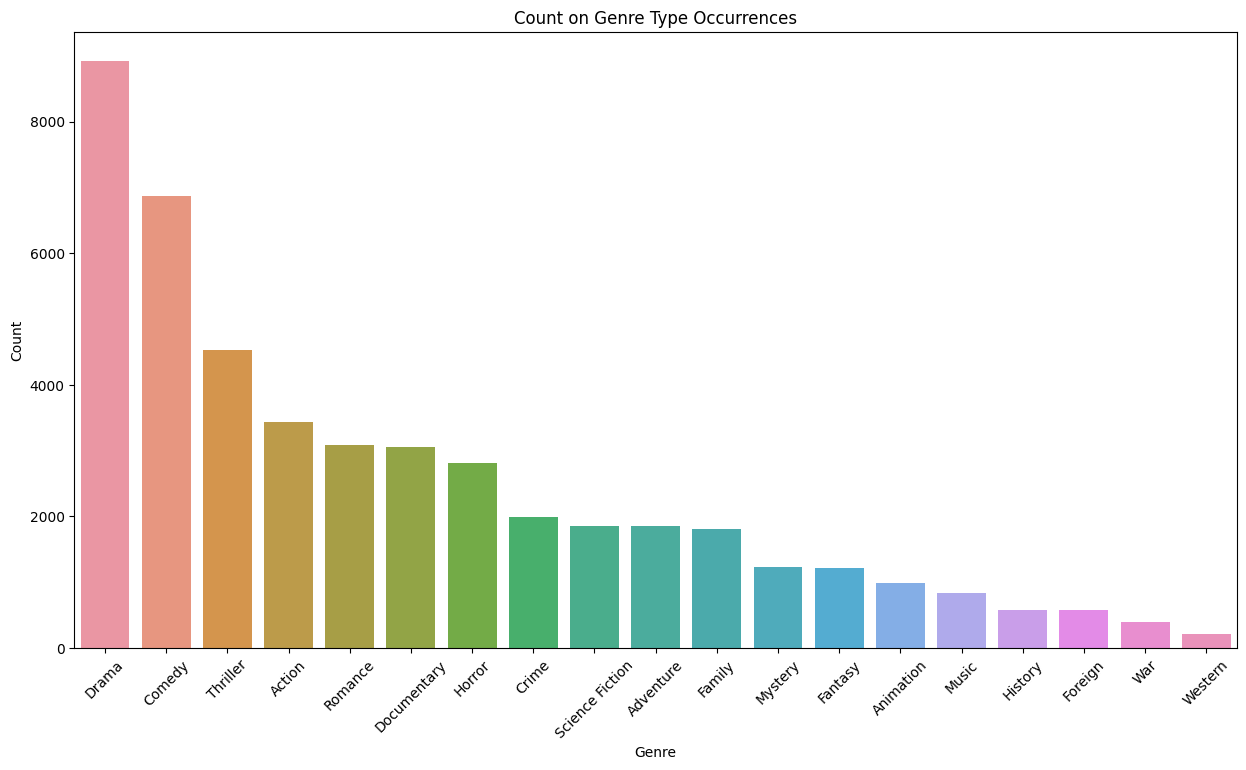

In [11]:
#Counting number of genre occurrences
genre_value_counts = pd.DataFrame(pd.Series([x for item in df_filtered.genres for x in item]).value_counts()).reset_index()
genre_value_counts.columns = ['Genre', 'Count']
plt.figure(figsize=(15,8))
plt.title('Count on Genre Type Occurrences')
plt.xticks(rotation=45)
sns.barplot(x='Genre',y='Count', data=genre_value_counts)
plt.show()

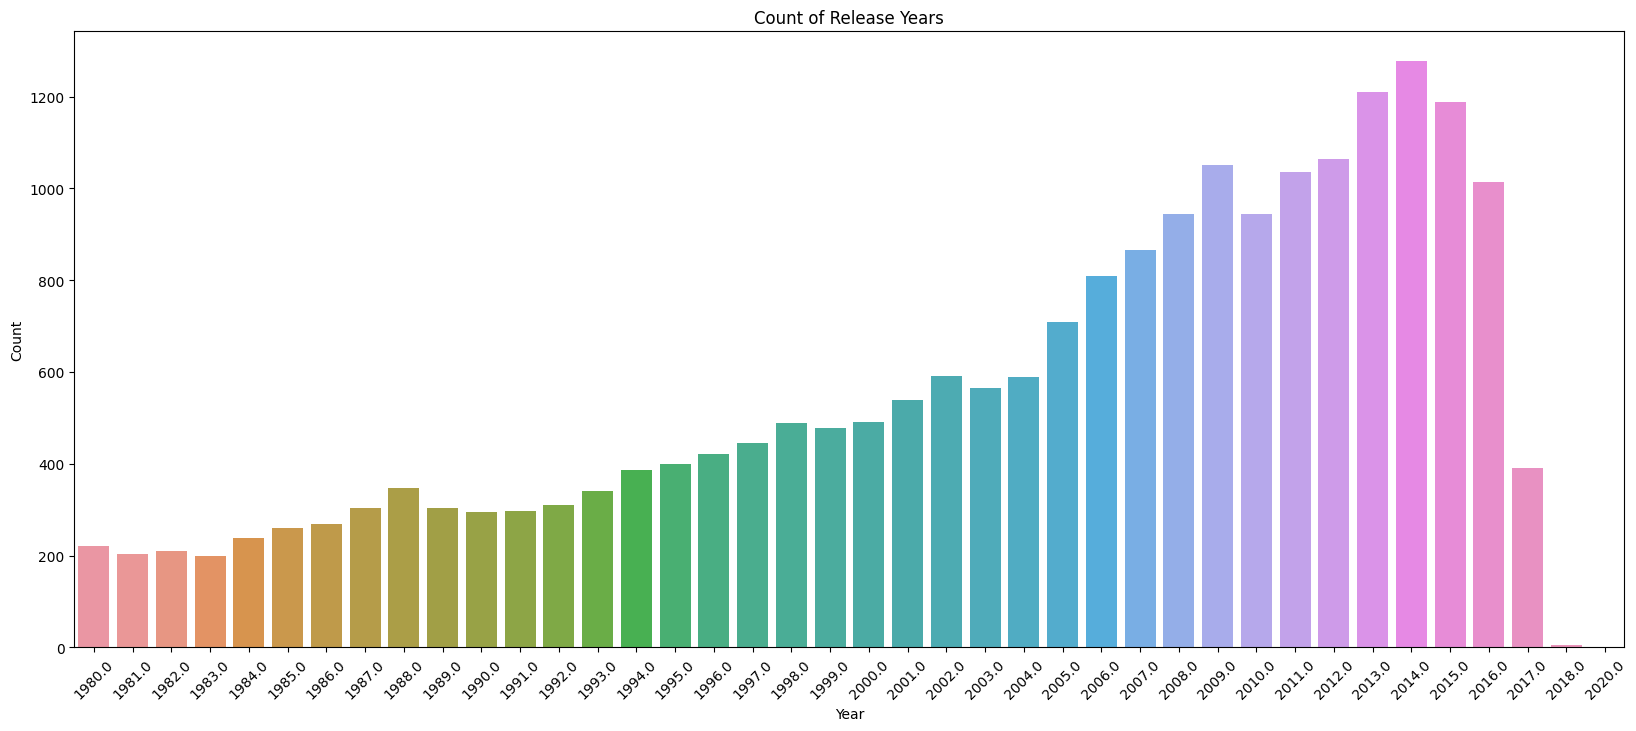

In [12]:
#Number of Movies per release year visualization
release_year_counts = pd.DataFrame(df_filtered['release_year'].value_counts()).reset_index()
release_year_counts.columns = ['Year', 'Count']
plt.figure(figsize=(20,8))
plt.title('Count of Release Years')
plt.xticks(rotation=45)
sns.barplot(x='Year',y='Count', data=release_year_counts)
plt.show()

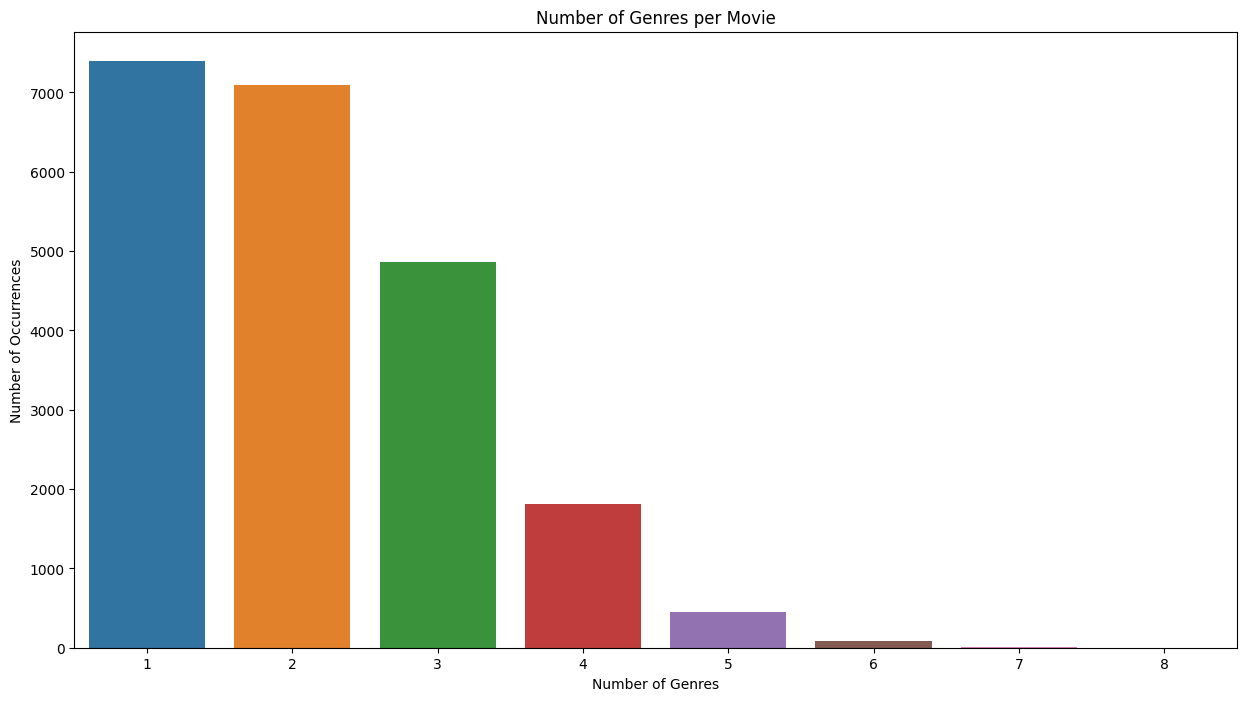

In [13]:
#Visualizing how many movies have multi-labels 

genre_counts_per_movie = pd.DataFrame(pd.DataFrame(df_filtered.genres.str.len()).value_counts()).reset_index()
genre_counts_per_movie.columns = ['Number of Genres', 'Number of Occurrences']
plt.figure(figsize=(15,8))
sns.barplot(x='Number of Genres',y='Number of Occurrences', data=genre_counts_per_movie)
plt.title('Number of Genres per Movie')
plt.show()

#Most movies have 1 or 2 genres mostly

Removing movies that have duplicated title names throughout the dataframe. Movies that do not have any overview is also removed.

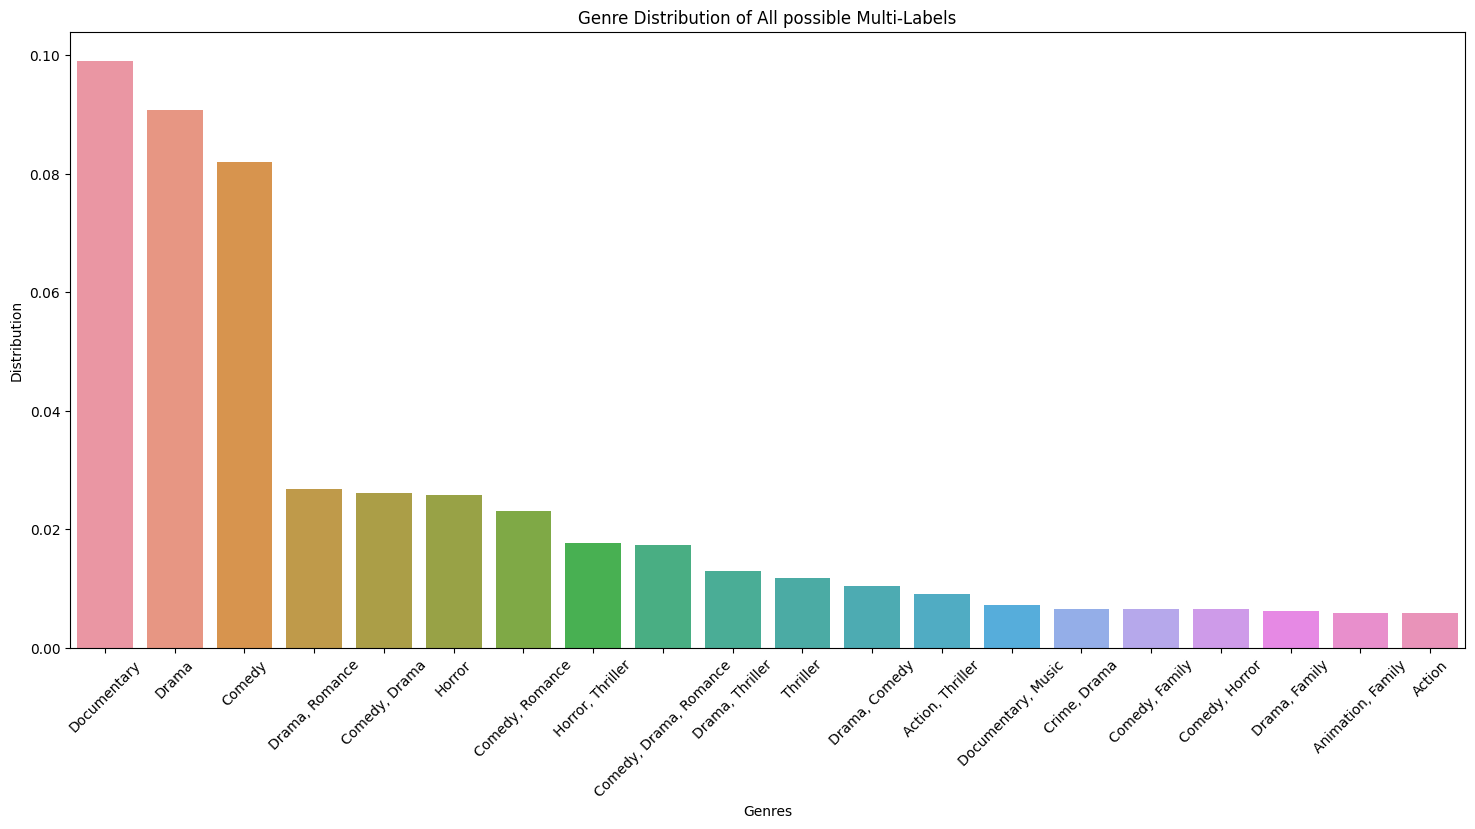

In [14]:
#Plotting Genre distribution

genre_dis = df_filtered['genres'].apply(lambda x: ', '.join(tag for tag in x)).value_counts(normalize=True)
genre_dis = pd.DataFrame(genre_dis).reset_index()
genre_dis.columns = ['Genres', 'Distribution']
plt.figure(figsize=(18,8))
plt.xticks(rotation=45)
plt.title('Genre Distribution of All possible Multi-Labels')
sns.barplot(data = genre_dis[:20], x='Genres', y='Distribution', dodge=False)
plt.show()

There exists a class imbalance

Genre of Drama exists frequently in groups and also alone

Documentary does not exists much as multilabel, but mostly exists alone

In [15]:
df_preprocessed = df_filtered.copy()

In [16]:
# There are some terms with occurrence as low as 1
sum(df_preprocessed['genres'].apply(lambda x: ', '.join(tag for tag in x)).value_counts()==1)

1411

In [17]:
#Number of unique genres

(df_preprocessed['genres'].apply(lambda x: ', '.join(tag for tag in x))).nunique()

2440

In [18]:
genre_combinations_df =pd.DataFrame(df_preprocessed['genres'].apply(lambda x: ', '.join(tag for tag in x)).value_counts()).reset_index()
genre_combinations_df.columns = ['genres', 'count']

count_one_genres = genre_combinations_df[genre_combinations_df['count']==1]
count_one_genres  = count_one_genres.reset_index(drop=True)

In [19]:
unique_indexes = pd.DataFrame(df_preprocessed['genres'].apply(lambda x: ', '.join(tag for tag in x))).merge(count_one_genres,
                                                                                          how='left',
                                                                                          on='genres')
unique_indexes = unique_indexes[unique_indexes['count'].notna()].index

In [20]:
#Removing rows who has unique genres

df_preprocessed = df_preprocessed.loc[~df_preprocessed.index.isin(unique_indexes)].reset_index(drop=True)

For overviews:

- Removing puctuation
- Tokenization: converting raw text into words
- Removing stopwords: such as the, am, is, etc.
- Lemmatizing: converting words with different suffixes to their roots -> reduces to a dictionary word (ex: converter, convert, converting becomes convert)

In [21]:
#Removing puctuation

def remove_punctuation(text):
    removed_txt = "".join([word for word in text if word not in string.punctuation])
    return removed_txt

df_preprocessed['overview_cleaned'] = df_preprocessed['overview'].apply(lambda x: remove_punctuation(x))

In [22]:
#Tokenization
#splitting on one or more nonword characters (W+)
def tokenize(text):
    tokens = re.split('\W+', text)
    return tokens

df_preprocessed['overview_cleaned'] = df_preprocessed['overview_cleaned'].apply(lambda x: tokenize(x.lower()))

In [23]:
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('omw-1.4')

In [24]:
#Removing stopwords
#if word is not in stopwords list, it is being added to the list 

stopword_lst = stopwords.words('english')
stopword_lst.extend(['film','young','life', 'must', 'new', 'one', 'year', 'find','take','make', 'story','first', 'man' ,'two', 'three','four',  
                     'five','six','nine', 'ten', 'including'])

def remove_stopwords(tokens):
    text_clean = [word for word in tokens if word not in stopword_lst]
    return text_clean

df_preprocessed['overview_cleaned'] = df_preprocessed['overview_cleaned'].apply(lambda x: remove_stopwords(x))

In [25]:
#Lemmatizing with WordNetLemmatizer
wn = WordNetLemmatizer()

def lemmatize(tokens):
    text_clean = [wn.lemmatize(word) for word in tokens]
    return text_clean

df_preprocessed['overview_cleaned'] = df_preprocessed['overview_cleaned'].apply(lambda x: lemmatize(x))  

Downloading movie posters (Following commented out lines can be used in order to download movie posters)

In [26]:
#Using tmdbv3api in order to extract images

#from tmdbv3api import TMDb
#from tmdbv3api import Movie
#from urllib.error import HTTPError
#
#tmdb = TMDb()
#tmdb.api_key = '8f5b62fbdfa00807785b52138e1b5a57'
#movie = Movie()

In [27]:
#empty_images = []
#for i in range(len(df_preprocessed)):
#    try:
#        search = movie.search(df_preprocessed['original_title'][i])
#        imgURL = f"http://image.tmdb.org/t/p/w185/{search[0].poster_path}"
#        name_of_download = str(df_preprocessed['id'][i]) + '.jpg'
#        urllib.request.urlretrieve(imgURL, f"./FinalProject/image_path/{name_of_download}")
#        
#    except:
#        empty_images.append(df_preprocessed['id'][i])
#        pass

In [28]:
#Getting image names since they contain ids in the df_preprocessed data frame

from os import listdir
from os.path import isfile, join

mypath = "tmdb_data/images"
image_names = [f for f in listdir(mypath) if isfile(join(mypath, f))]
image_ids = pd.DataFrame(pd.DataFrame(image_names)[0].str.split('.',expand=True)[0])
df_preprocessed['id'] = df_preprocessed['id'].astype(int)
image_ids = image_ids.rename({0:'id'}, axis=1)
image_ids['id'] = image_ids['id'].astype(int)
image_genres = image_ids.copy()

In [29]:
image_genres = image_genres.merge(df_preprocessed[['id','genres']], how='left', on='id')

In [31]:
image_size = (128, 128)

In [32]:
poster_images = np.zeros((image_ids.shape[0], 128,128, 3), dtype = "uint8")

#poster_images = np.zeros((image_ids.shape[0], 278, 185, 3), dtype = "uint8")

for index, i in enumerate(image_ids['id']):
    try:
        loaded = tf.keras.preprocessing.image.load_img("tmdb_data/images/{}.jpg".format(i),target_size = image_size)
        poster_images[index, 0:image_size[0], 0:image_size[1], :] = loaded
    except:
        pass

In [33]:
print(poster_images[0].shape)

(128, 128, 3)


Example images

['Horror']


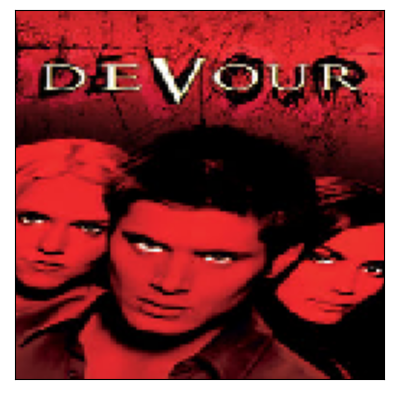

In [34]:
plt.imshow(poster_images[0])
plt.xticks([])
plt.yticks([])
print(image_genres['genres'][0])
plt.show()

['Documentary']


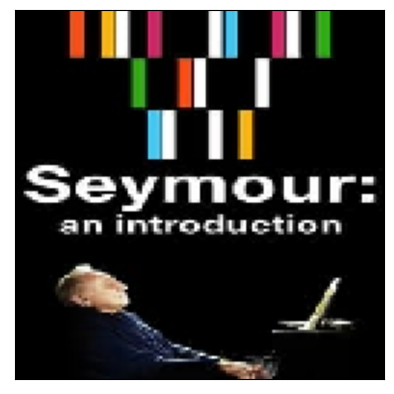

In [35]:
plt.imshow(poster_images[1])
plt.xticks([])
plt.yticks([])
print(image_genres['genres'][1])
plt.show()

In [36]:
#df_preprocessed['overview_cleaned'] = df_preprocessed['overview_cleaned'].apply(lambda x: ' '.join(x))

### Splitting into Train and Test Sets with Multilabel Data Stratification

In [37]:
#Creating target data frame with MultiLabelBinarizer

binarizer = MultiLabelBinarizer()
y = binarizer.fit_transform(df_filtered['genres'])
target_df = pd.DataFrame(y, columns=binarizer.classes_)

In [38]:
target_df = target_df.loc[~target_df.index.isin(unique_indexes)].reset_index(drop=True)

In [39]:
X = []
overviews = list(df_preprocessed['overview_cleaned'])
for overview in overviews:
    X.append(overview)

X = np.array(X).reshape(-1,1)
y = np.array(target_df)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y)

print(f'Training set shape, Percentage: {len(X_train)}, {len(X_train)/len(target_df):.0%}\n'
      f'Test set shape, Percentage: {len(X_test)}, {len(X_test)/len(target_df):.0%}')

Training set shape, Percentage: 16236, 80%
Test set shape, Percentage: 4059, 20%


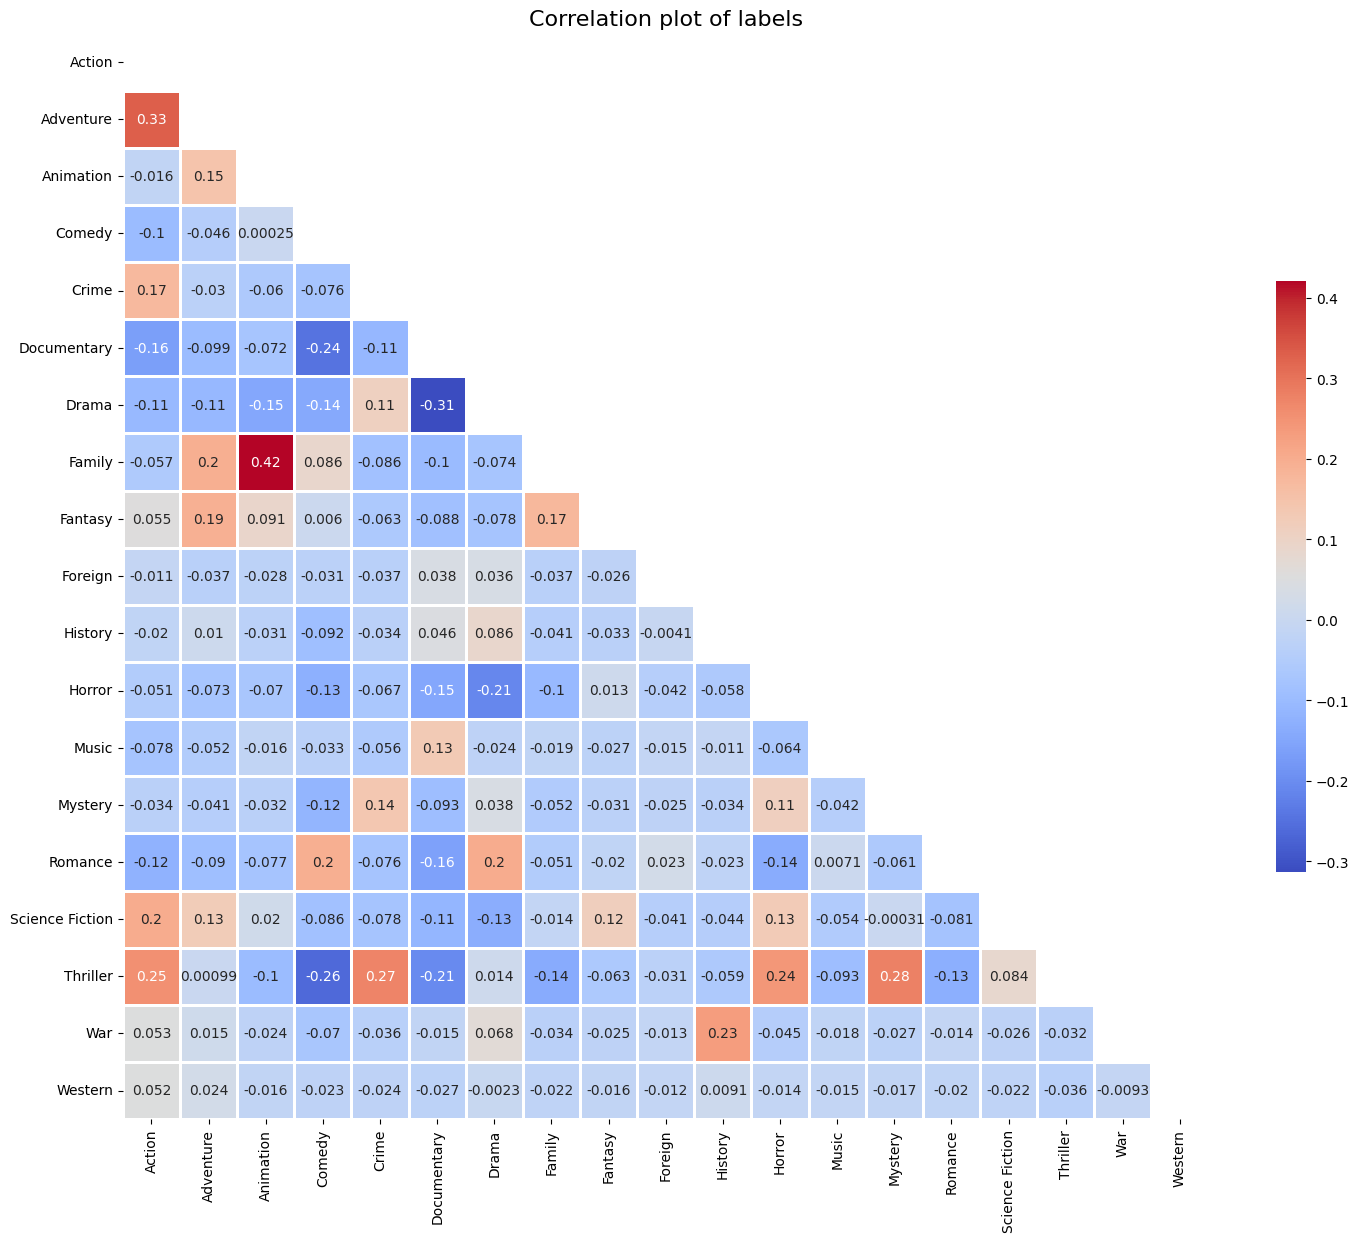

In [41]:
#Creating correlation plot of targets

corr = target_df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(15, 20)) 
heatmap = sns.heatmap(corr, 
                      square = True,
                      linewidths = 1,
                      mask=mask,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .3},
                      annot = True)

#adding column names as labels
ax.set_yticklabels(corr.columns, rotation = 0)
ax.set_xticklabels(corr.columns)
plt.tight_layout()
plt.title("Correlation plot of labels", fontsize=16)
plt.show()

Adventure genre frequently occurs with Action genre

Family genre frequently occurs with Animation genre

In [42]:
#concatenating target column and preprocessed df 
df_merged = pd.concat([df_preprocessed,target_df], axis=1)

In [43]:
#Creating count of words in overview column for whole data frame
words_list=[word for line in df_preprocessed['overview_cleaned'].dropna() for word in line]
word_counts=Counter(words_list).most_common(50)
word_df=pd.DataFrame(word_counts)
word_df.columns=['word','count']

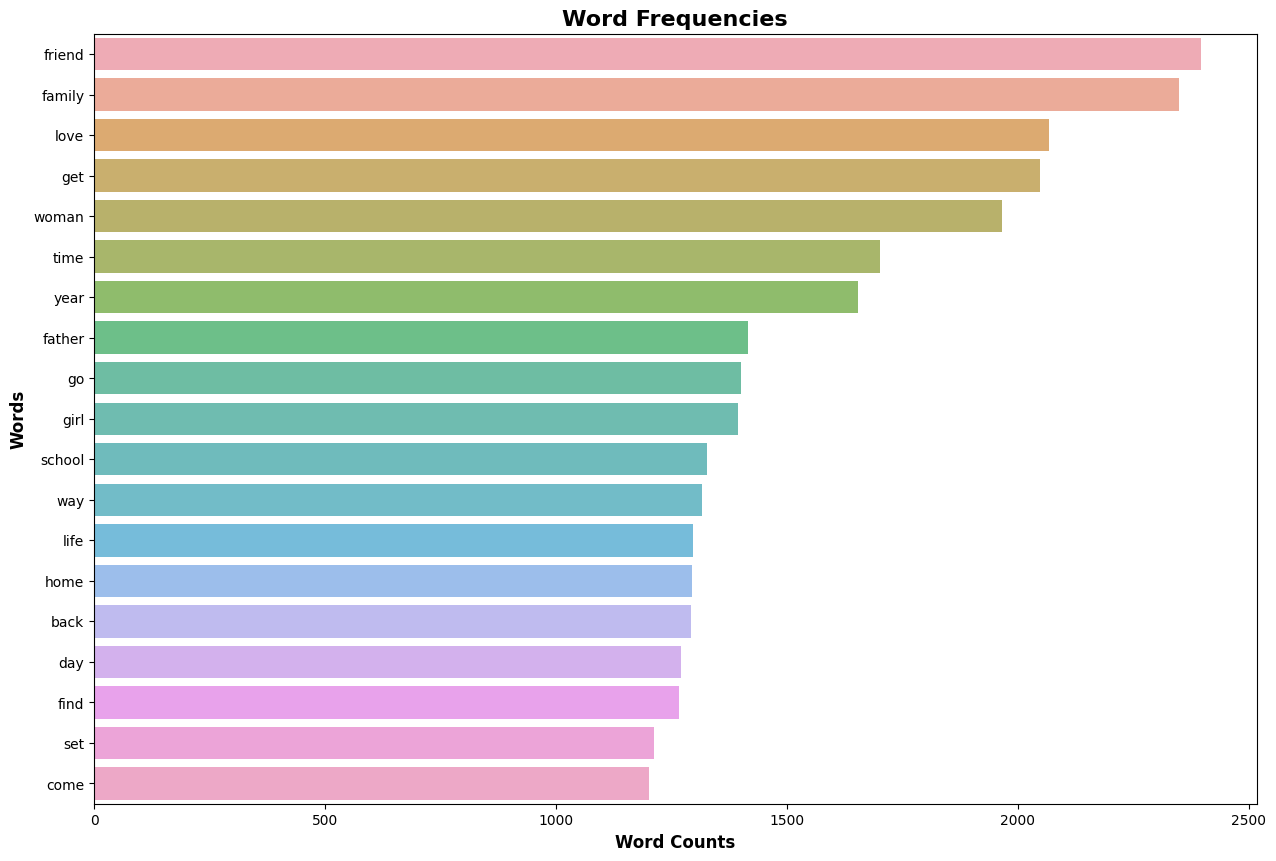

In [44]:
#Plotting most frequent words in overviews

df_values = word_df[1:20]
plt.figure(figsize=(15,10))
sns.barplot(x=df_values.values[:,1],y=df_values.values[:,0], alpha=0.8)
plt.title("Word Frequencies", fontweight='bold', fontsize=16)
plt.ylabel("Words", fontweight='bold', fontsize=12)
plt.xlabel("Word Counts", fontweight='bold', fontsize=12)
plt.show()

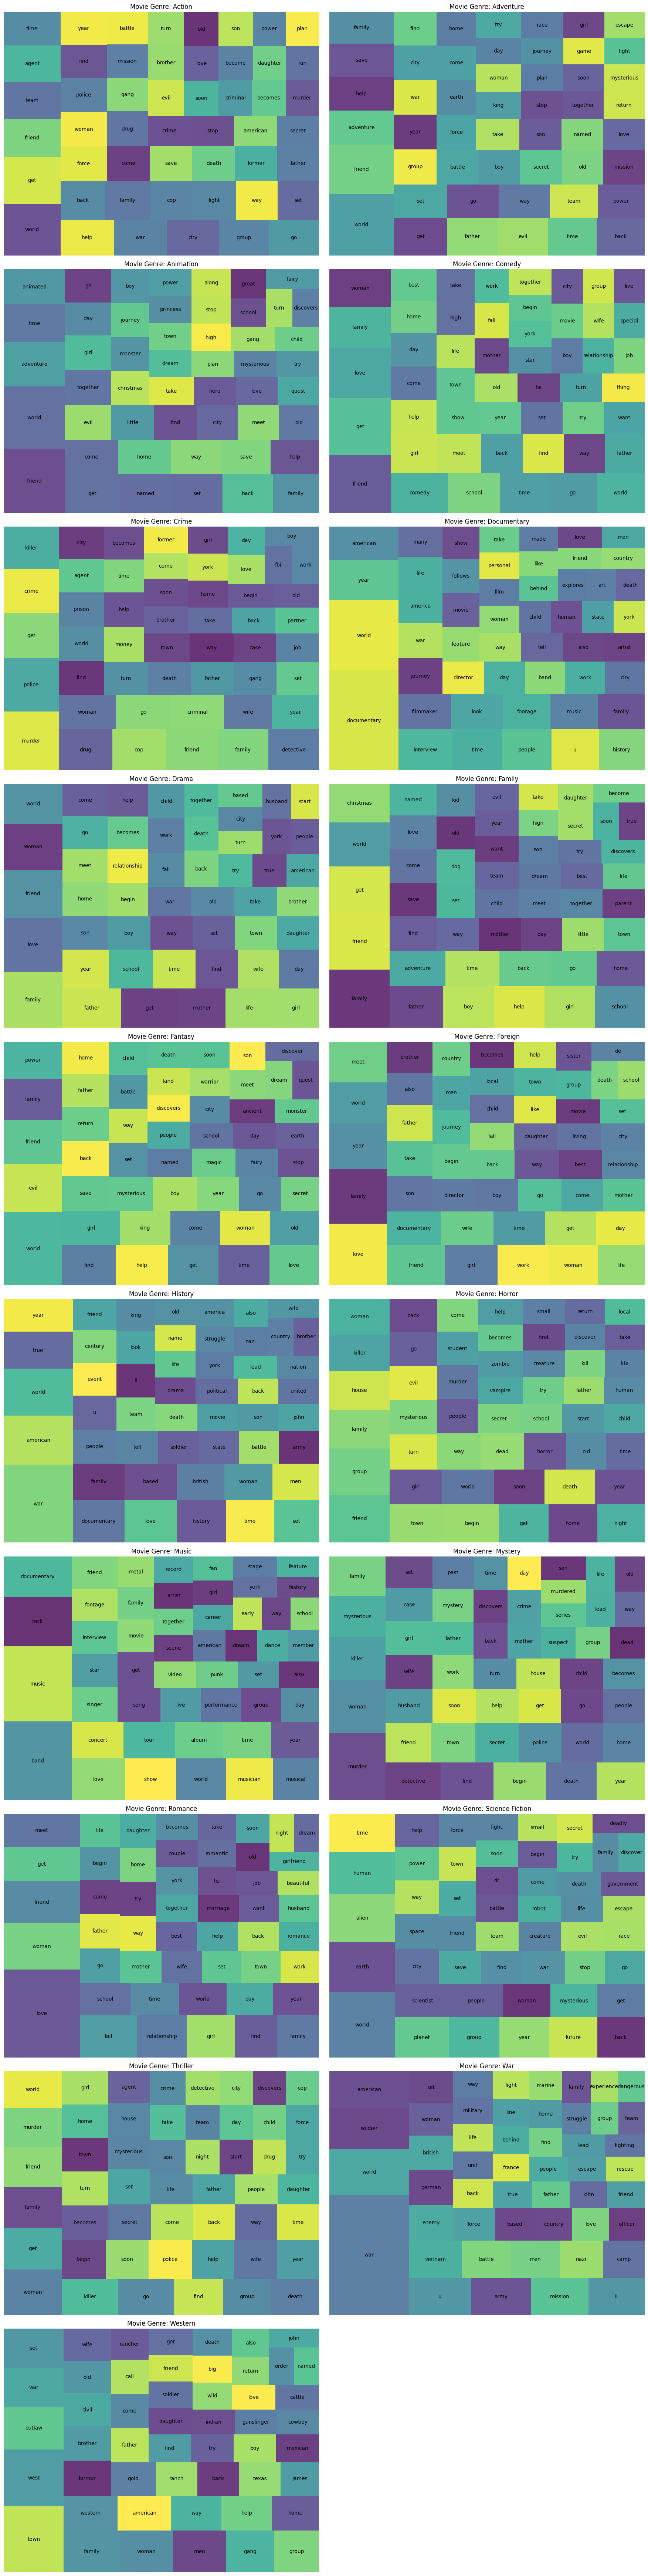

In [45]:
fig = plt.figure(figsize=(18, 70))
num_cols = 2
num_rows = math.ceil(len(target_df.columns)/num_cols)

for idx, genre in enumerate(target_df.columns):
    words_list=[word for line in df_merged[df_merged[genre]==1]['overview_cleaned'].dropna() for word in line]
    word_counts=Counter(words_list).most_common(50)
    word_df=pd.DataFrame(word_counts)
    word_df.columns=['word','count']
    ax = fig.add_subplot(num_rows, num_cols, idx+1)
    squarify.plot(sizes=word_df['count'], 
              label=word_df['word'], 
              alpha=.8)
    plt.tight_layout()
    ax.axis("off")
    ax.set(title='Movie Genre: {0}'.format(genre))

### TF-IDF vectorization

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_fscore_support, hamming_loss,accuracy_score
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid

import tqdm

In [47]:
#Result metrics

def calculating_results(y_true, y_pred, index):
    """Calculate accuracy, precision, recall, f1 score, hamming loss"""
    
    metrics = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    metrics2 = hamming_loss(y_true, y_pred)
    metrics3 = accuracy_score(y_true, y_pred)
    performance = {'precision': metrics[0], 'recall': metrics[1], 'f1': metrics[2], 'hamming_loss': metrics2,'accuracy': metrics3}
    return pd.DataFrame(performance, index=[index])

In [48]:
#class for switching between models

class ModelSwitcher(BaseEstimator):
    
    def __init__(self, estimator=RandomForestClassifier()):
        """
        A Custom BaseEstimator that can switch between classifiers.
        
        Parameters
        ----------
        estimator: sklearn object, the classifier
        """
        self.estimator = estimator
    
    def fit(self, X, y):
        self.estimator.fit(X, y)
        return self
    
    def predict(self, X):
        return self.estimator.predict(X)
    
    def predict_proba(self, X):
        return self.estimator.predict_proba(X)
    
    def score(self, X, y):
        return self.estimator.calculating_results(X, y)

In [49]:
multiple_models_pipe = Pipeline([
                        ('tfidf', TfidfVectorizer()),
                        ('clf', ModelSwitcher())
                       ])

In [56]:
param_grid = ParameterGrid({
        'clf__estimator': [
            MultiOutputClassifier(SGDClassifier(class_weight='balanced', random_state=0, loss='modified_huber'), n_jobs=-1),
            MultiOutputClassifier(LinearSVC(class_weight='balanced', random_state=0), n_jobs=-1),
            RandomForestClassifier(class_weight='balanced', random_state=0),
            XGBClassifier(random_state=0, n_jobs=-1),
        ],
        'tfidf__ngram_range': [(1,1), (1,2)]
        })


In [58]:
models = ['mo_sgd1', 'mo_sgd2', 'mo_svm1', 'mo_svm2', 
          'rf1', 'rf2','xgb1', 'xgb2']

In [59]:
scores = pd.DataFrame()

In [60]:
for model, params in tqdm(zip(models, param_grid), total=len(models)):
    multiple_models_pipe.set_params(**params)
    multiple_models_pipe.fit(X_train.ravel(), y_train)
    y_pred = multiple_models_pipe.predict(X_test.ravel())
    results = calculating_results(y_test, y_pred, model)
    scores = pd.concat([scores, results])

100%|█████████████████████████████████████████████| 8/8 [04:26<00:00, 33.35s/it]


In [61]:
scores

precision    recall        f1  hamming_loss  accuracy
mo_sgd1   0.539752  0.613150  0.571893      0.096096  0.179601
mo_sgd2   0.582392  0.612532  0.594160      0.086098  0.217295
mo_svm1   0.552401  0.582005  0.564986      0.092906  0.184528
mo_svm2   0.605368  0.576690  0.586398      0.082170  0.231831
rf1       0.516692  0.138302  0.184673      0.096679  0.107908
rf2       0.600866  0.132616  0.178723      0.096731  0.099532
xgb1      0.661302  0.341367  0.438051      0.086124  0.187731
xgb2      0.607964  0.393400  0.472377      0.087901  0.179847

Best results seems to be extracted from tfidf of (1,2) ngrams and LinearSVC

Hyperparameter tuning to ensemble methods to see if they can be improved

In [62]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), sublinear_tf=True,
                                   min_df=2, max_df=0.5)
RF = RandomForestClassifier(random_state=0,class_weight='balanced')

In [63]:
pipe_RF = Pipeline(steps=[('vectorizer',vectorizer), ('clf', RF)])

In [64]:
pipe_RF = Pipeline(steps=[('vectorizer',vectorizer), ('clf', RandomForestClassifier(random_state=0,class_weight='balanced'))])

In [95]:
parameters_vectorizer = {
    "vectorizer__ngram_range": [(1, 2)],
    "vectorizer__sublinear_tf": [True]
}

In [66]:
parametersRF = {
    "clf__n_estimators": [5, 200],
    "clf__min_samples_split" : [5, 10],
}

In [67]:
parametersRF.update(parameters_vectorizer)

In [68]:
clf_RF = GridSearchCV(estimator=pipe_RF, param_grid=parametersRF, verbose=10, n_jobs=1, cv=3 ,scoring="f1_macro")
clf_RF.fit(X_train.ravel(), y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3; 1/4] START clf__min_samples_split=5, clf__n_estimators=5, vectorizer__ngram_range=(1, 2), vectorizer__sublinear_tf=True
[CV 1/3; 1/4] END clf__min_samples_split=5, clf__n_estimators=5, vectorizer__ngram_range=(1, 2), vectorizer__sublinear_tf=True;, score=0.178 total time=   1.6s
[CV 2/3; 1/4] START clf__min_samples_split=5, clf__n_estimators=5, vectorizer__ngram_range=(1, 2), vectorizer__sublinear_tf=True
[CV 2/3; 1/4] END clf__min_samples_split=5, clf__n_estimators=5, vectorizer__ngram_range=(1, 2), vectorizer__sublinear_tf=True;, score=0.162 total time=   1.6s
[CV 3/3; 1/4] START clf__min_samples_split=5, clf__n_estimators=5, vectorizer__ngram_range=(1, 2), vectorizer__sublinear_tf=True
[CV 3/3; 1/4] END clf__min_samples_split=5, clf__n_estimators=5, vectorizer__ngram_range=(1, 2), vectorizer__sublinear_tf=True;, score=0.173 total time=   1.6s
[CV 1/3; 2/4] START clf__min_samples_split=5, clf__n_estimators=200, vect

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(max_df=0.5, min_df=2,
                                                        ngram_range=(1, 2),
                                                        sublinear_tf=True)),
                                       ('clf',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=0))]),
             n_jobs=1,
             param_grid={'clf__min_samples_split': [5, 10],
                         'clf__n_estimators': [5, 200],
                         'vectorizer__ngram_range': [(1, 2)],
                         'vectorizer__sublinear_tf': [True]},
             scoring='f1_macro', verbose=10)

In [69]:
pipe_rf = clf_RF.best_estimator_

In [72]:
calculating_results(y_test, pipe_rf.predict(X_test.ravel()),'rf')

precision    recall        f1  hamming_loss  accuracy
rf   0.456167  0.208132  0.276663      0.106249  0.092387

Still not good enough as LinearSVC

### Neural Networks

Using pretrained word vectors (such as Glove) to get better results

In [83]:
X_train = X_train.ravel()
X_train = pd.DataFrame(X_train)[0].apply(lambda x: ' '.join(x))
X_test = X_test.ravel()
X_test = pd.DataFrame(X_test)[0].apply(lambda x: ' '.join(x))

In [84]:
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [85]:
def create_corpus(df):  
    corpus = []
    for text in df:
        words = [word for word in word_tokenize(text)]
        corpus.append(words)
    return corpus

In [86]:
corpus = create_corpus(X_train)
num_words = len(corpus)

In [87]:
max_len = 50

In [88]:
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

In [89]:
#Mapping each word to a sequence

train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [90]:
#padding each sequence with max_len

train_padded = pad_sequences(
    train_sequences, maxlen=max_len, padding = "post", truncating = "post"
)

test_padded = pad_sequences(
    test_sequences, maxlen=max_len, padding = "post", truncating = "post"
)

In [91]:
#word_index is the dictionary in which keys are the words that are found in the corpus and
#values are just assignments of words

word_index = tokenizer.word_index

print(f"Number of unique words: {len(word_index)}")

Number of unique words: 42655


Using Glove Word embeddings in order to convert text inputs through their word embeddings

In order to use Glove Word embeddings, following line of code would download the zip file

In [92]:
#urllib.request.urlretrieve('https://nlp.stanford.edu/data/glove.6B.zip','glove.6B.zip')
#!unzip glove*.zip

In [93]:
embedding_dict = {}

with open("glove.6B.100d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], "float32")
        embedding_dict[word] = vectors
        
f.close()

In [94]:
#For each word in index, assign the vector to the word in the corpus

num_words = len(word_index) + 1

embedding_matrix = np.zeros((num_words, 100))

for word, index in word_index.items():
    if index<num_words:
        emb_vector = embedding_dict.get(word)
    
        embedding_vector = embedding_dict.get(word)
        
        if emb_vector is not None:
            embedding_matrix[index] = emb_vector

In [95]:
print(train_padded.shape)
print(y_train.shape)

(16236, 50)
(16236, 19)


In [96]:
print(test_padded.shape)
print(y_test.shape)

(4059, 50)
(4059, 19)


### LSTM Model

In [61]:
lstm_model= keras.models.Sequential([
                keras.layers.Embedding(num_words,
                                       100, 
                                       embeddings_initializer=Constant(embedding_matrix), 
                                       trainable=False, 
                                       input_length = max_len),
                keras.layers.LSTM(100),
                keras.layers.Dropout(0.1),
                keras.layers.Dense(target_df.shape[1], activation = "sigmoid")
            ])

lstm_model.summary()

2022-09-09 14:08:19.991942: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-09 14:08:19.992579: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           4258000   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 19)                1919      
Total params: 4,340,319
Trainable params: 82,319
Non-trainable params: 4,258,000
_________________________________________________________________


In [62]:
#plot_model(lstm_model, to_file='lstm_model.png', show_shapes=True, show_layer_names=True)

In [63]:
lstm_model.compile(loss='binary_crossentropy', 
                   optimizer=keras.optimizers.Adam(3e-4), 
                   metrics=['accuracy'])

In [64]:
lstm_history = lstm_model.fit(
    train_padded,
    y_train,
    epochs=5,
    validation_data=(test_padded, y_test)
)

Train on 16236 samples, validate on 4059 samples
Epoch 1/5


2022-09-09 14:08:24.879082: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_2849_3334' and '__inference___backward_standard_lstm_2849_3334_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_3454' both implement 'lstm_bfcf327a-2093-4b73-b446-0119330cad1b' but their signatures do not match.


16224/16236 [============================>.] - ETA: 0s - loss: 0.3176 - accuracy: 0.8870

2022-09-09 14:09:19.354993: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_5178_specialized_for_sequential_lstm_StatefulPartitionedCall_at___inference_distributed_function_5538' and '__inference_standard_lstm_5178' both implement 'lstm_2fb196e5-9693-4010-b2b3-a74ff1f4ed04' but their signatures do not match.


16236/16236 [==============================] - 61s 4ms/sample - loss: 0.3176 - accuracy: 0.8870 - val_loss: 0.2858 - val_accuracy: 0.8951
Epoch 2/5
16236/16236 [==============================] - 61s 4ms/sample - loss: 0.2771 - accuracy: 0.8946 - val_loss: 0.2586 - val_accuracy: 0.8985
Epoch 3/5
16236/16236 [==============================] - 60s 4ms/sample - loss: 0.2533 - accuracy: 0.9008 - val_loss: 0.2421 - val_accuracy: 0.9045
Epoch 4/5
16236/16236 [==============================] - 81s 5ms/sample - loss: 0.2379 - accuracy: 0.9057 - val_loss: 0.2349 - val_accuracy: 0.9048
Epoch 5/5
16236/16236 [==============================] - 101s 6ms/sample - loss: 0.2301 - accuracy: 0.9074 - val_loss: 0.2269 - val_accuracy: 0.9087


In [65]:
lstm_model_train_eval = lstm_model.evaluate(train_padded, y_train)
lstm_model_test_eval = lstm_model.evaluate(test_padded, y_test)

16236/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

4059/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [66]:
print(f'Training Loss: {lstm_model_train_eval[0]}, Training Accuracy: {lstm_model_train_eval[1]}')
print(f'Test Loss: {lstm_model_test_eval[0]}, Test Accuracy: {lstm_model_test_eval[1]}')

Training Loss: 0.22310205875916797, Training Accuracy: 0.9103257656097412
Test Loss: 0.2269405432744812, Test Accuracy: 0.9086759090423584


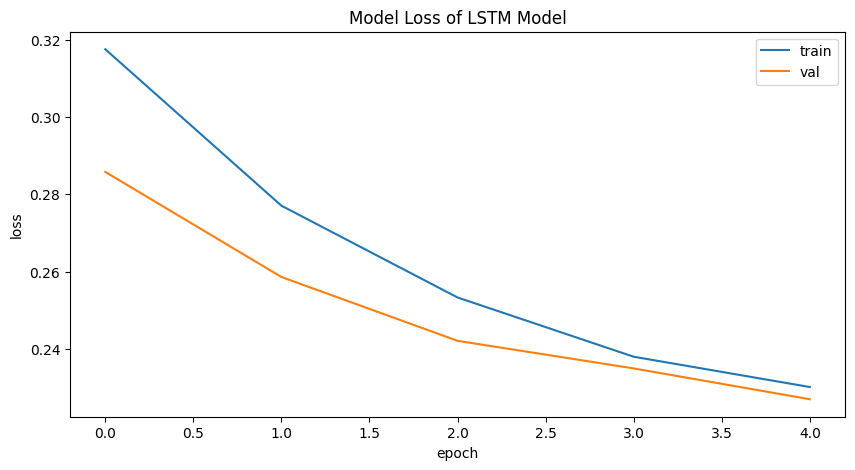

In [68]:
plt.figure(figsize=(10,5))
plt.plot(lstm_history.history["loss"])
plt.plot(lstm_history.history["val_loss"])
plt.title('Model Loss of LSTM Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

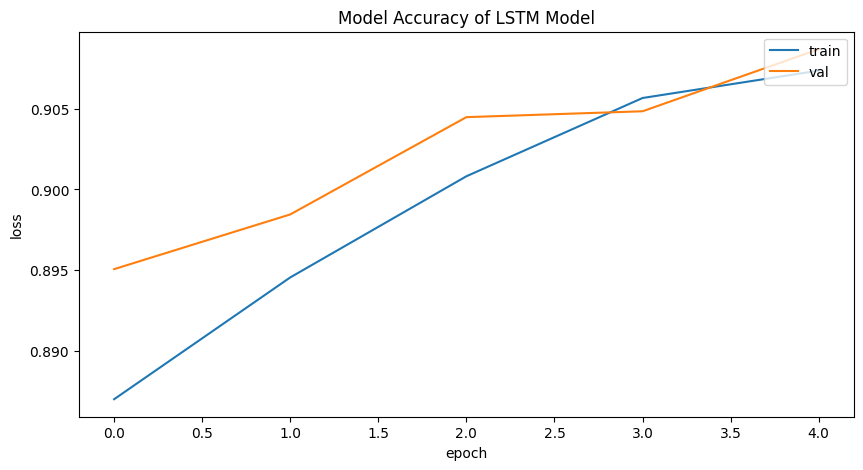

In [69]:
plt.figure(figsize=(10,5))
plt.plot(lstm_history.history["accuracy"])
plt.plot(lstm_history.history["val_accuracy"])
plt.title('Model Accuracy of LSTM Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [116]:
sequences = tokenizer.texts_to_sequences(X_test)
padded = pad_sequences(sequences, maxlen=max_len, padding = "post", truncating = "post")

In [71]:
pred = lstm_model.predict([padded])
pred_round = pred.round().astype('int')

2022-09-09 14:16:09.659019: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_lstm_with_fallback_15945' and '__inference_standard_lstm_15834_specialized_for_sequential_lstm_StatefulPartitionedCall_at___inference_distributed_function_16138' both implement 'lstm_b420952b-8dc2-45af-8ea4-743a68d80819' but their signatures do not match.


In [72]:
from sklearn.metrics import multilabel_confusion_matrix

In [74]:
target_names = binarizer.classes_

In [76]:
print("Classification Report of LSTM Model:")
print(classification_report(y_test, pred_round, target_names = target_names))

Classification Report of LSTM Model:
                 precision    recall  f1-score   support

         Action       0.53      0.30      0.38       576
      Adventure       0.00      0.00      0.00       278
      Animation       0.00      0.00      0.00       155
         Comedy       0.67      0.38      0.48      1271
          Crime       0.00      0.00      0.00       343
    Documentary       0.72      0.71      0.71       594
          Drama       0.67      0.51      0.58      1654
         Family       0.89      0.05      0.10       298
        Fantasy       0.00      0.00      0.00       174
        Foreign       0.00      0.00      0.00        93
        History       0.00      0.00      0.00        94
         Horror       0.00      0.00      0.00       503
          Music       0.00      0.00      0.00       139
        Mystery       0.00      0.00      0.00       194
        Romance       1.00      0.01      0.01       543
Science Fiction       0.52      0.09      0.16    

### NN with GRU

In [77]:
#Building the model

rnn_model = keras.models.Sequential([
    keras.layers.Embedding(num_words,
                           100, 
                           embeddings_initializer=Constant(embedding_matrix), 
                           trainable=False, 
                           input_length = max_len),
    keras.layers.GRU(units = 256),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(60, activation = "relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(target_df.shape[1], activation = "sigmoid")
])

rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           4258000   
_________________________________________________________________
gru (GRU)                    (None, 256)               274944    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 60)                15420     
_________________________________________________________________
batch_normalization (BatchNo (None, 60)                240       
_________________________________________________________________
dense_2 (Dense)              (None, 19)                1159      
Total params: 4,549,763
Trainable params: 291,643
Non-trainable params: 4,258,120
______________________________________

In [78]:
plot_model(rnn_model, to_file='rnn_model.png', show_shapes=True, show_layer_names=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [79]:
rnn_model.compile(loss='binary_crossentropy', 
                  optimizer=keras.optimizers.Adam(learning_rate=3e-4), 
                  metrics=['accuracy'])

In [80]:
early_stop = keras.callbacks.EarlyStopping(monitor = "val_accuracy",
                                           patience = 5)

model_save = keras.callbacks.ModelCheckpoint("checkpoint_news",
                                             monitor = "val_accuracy",
                                             save_best_only = True,
                                             save_weights_only = True,
                                             mode = "max")

rnn_history = rnn_model.fit(train_padded, y_train,
                            epochs = 20, verbose = 1, batch_size=64,
                            validation_data = (test_padded, y_test),
                            callbacks = [early_stop, model_save])

Train on 16236 samples, validate on 4059 samples
Epoch 1/20


2022-09-09 14:17:02.350474: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_gru_19486_20045_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_20184' and '__inference___backward_standard_gru_19486_20045' both implement 'gru_dfb9b582-2117-4318-92b9-fb05f7c4f6dc' but their signatures do not match.


16192/16236 [============================>.] - ETA: 0s - loss: 0.6636 - accuracy: 0.7626

2022-09-09 14:18:08.642650: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_gru_with_fallback_21238' and '__inference_standard_gru_21149_specialized_for_sequential_1_gru_StatefulPartitionedCall_at___inference_distributed_function_21470' both implement 'gru_88105edc-07c2-42db-8aef-59b9ec7b4adc' but their signatures do not match.


16236/16236 [==============================] - 75s 5ms/sample - loss: 0.6634 - accuracy: 0.7630 - val_loss: 0.5602 - val_accuracy: 0.8912
Epoch 2/20
16236/16236 [==============================] - 76s 5ms/sample - loss: 0.4433 - accuracy: 0.8876 - val_loss: 0.3452 - val_accuracy: 0.8951
Epoch 3/20
16236/16236 [==============================] - 74s 5ms/sample - loss: 0.3146 - accuracy: 0.8944 - val_loss: 0.2955 - val_accuracy: 0.8950
Epoch 4/20
16236/16236 [==============================] - 73s 5ms/sample - loss: 0.2926 - accuracy: 0.8945 - val_loss: 0.2872 - val_accuracy: 0.8951
Epoch 5/20
16236/16236 [==============================] - 76s 5ms/sample - loss: 0.2783 - accuracy: 0.8957 - val_loss: 0.2627 - val_accuracy: 0.8978
Epoch 6/20
16236/16236 [==============================] - 75s 5ms/sample - loss: 0.2563 - accuracy: 0.8998 - val_loss: 0.2494 - val_accuracy: 0.9019
Epoch 7/20
16236/16236 [==============================] - 74s 5ms/sample - loss: 0.2471 - accuracy: 0.9013 - val_loss

In [81]:
#rnn_model.load_weights("checkpoint_news")

In [ ]:
rnn_model_train_eval = rnn_model.evaluate(train_padded, y_train)
rnn_model_test_eval = rnn_model.evaluate(test_padded, y_test)

In [83]:
print(f'Training Loss: {lstm_model_train_eval[0]}, Training Accuracy: {lstm_model_train_eval[1]}')
print(f'Test Loss: {lstm_model_test_eval[0]}, Test Accuracy: {lstm_model_test_eval[1]}')

Training Loss: 0.22310205875916797, Training Accuracy: 0.9103257656097412
Test Loss: 0.2269405432744812, Test Accuracy: 0.9086759090423584


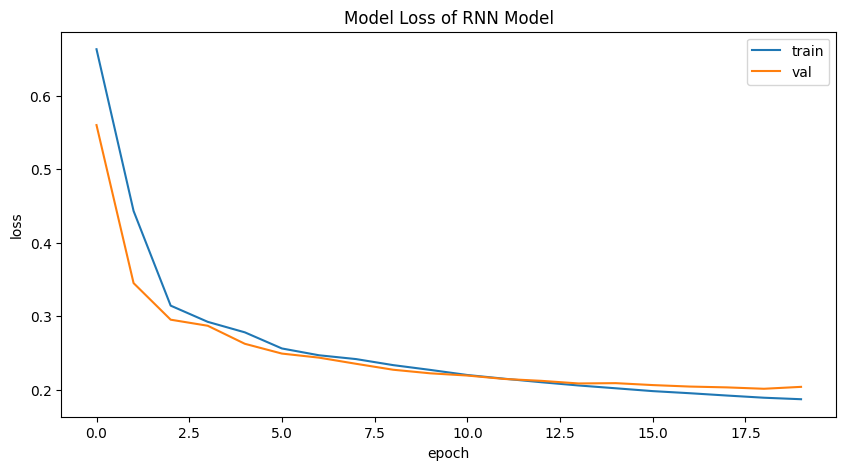

In [87]:
plt.figure(figsize=(10,5))
plt.plot(rnn_history.history["loss"])
plt.plot(rnn_history.history["val_loss"])
plt.title('Model Loss of RNN Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

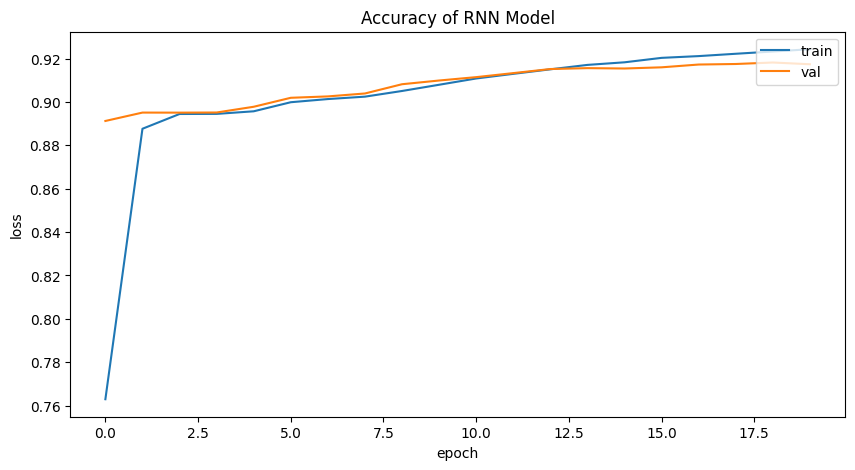

In [88]:
plt.figure(figsize=(10,5))
plt.plot(rnn_history.history["accuracy"])
plt.plot(rnn_history.history["val_accuracy"])
plt.title('Accuracy of RNN Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [86]:
pred = rnn_model.predict([padded])
pred_round = pred.round().astype('int')

2022-09-09 15:30:43.856273: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_gru_with_fallback_43045' and '__inference_standard_gru_42956_specialized_for_sequential_1_gru_StatefulPartitionedCall_at___inference_distributed_function_43221' both implement 'gru_afd71e89-34a9-4479-b0b0-c4be592b9566' but their signatures do not match.


In [89]:
print("Classification Report of RNN Model:")
print(classification_report(y_test, pred_round, target_names = target_names))

Classification Report of RNN Model:
                 precision    recall  f1-score   support

         Action       0.66      0.44      0.53       576
      Adventure       0.59      0.17      0.26       278
      Animation       0.64      0.30      0.41       155
         Comedy       0.72      0.53      0.61      1271
          Crime       0.55      0.29      0.38       343
    Documentary       0.85      0.66      0.74       594
          Drama       0.65      0.62      0.64      1654
         Family       0.65      0.33      0.44       298
        Fantasy       0.50      0.02      0.04       174
        Foreign       0.00      0.00      0.00        93
        History       0.33      0.01      0.02        94
         Horror       0.61      0.66      0.63       503
          Music       0.69      0.22      0.34       139
        Mystery       0.00      0.00      0.00       194
        Romance       0.64      0.30      0.41       543
Science Fiction       0.65      0.46      0.54     

### LSTM Model 2

In [100]:
lstm_model_2= keras.models.Sequential([
                keras.layers.Embedding(num_words,
                                       100, 
                                       embeddings_initializer=Constant(embedding_matrix), 
                                       trainable=False, 
                                       input_length = max_len),
                keras.layers.LSTM(100),
                keras.layers.Dropout(0.1),
                keras.layers.Dense(30),
                keras.layers.Dropout(0.1),
                keras.layers.Dense(target_df.shape[1], activation = "sigmoid")
            ])

lstm_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           4265600   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
_________________________________________________________________
dropout_3 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 19)                589       
Total params: 4,349,619
Trainable params: 84,019
Non-trainable params: 4,265,600
_______________________________________

In [101]:
lstm_model_2.compile(loss='binary_crossentropy', 
                   optimizer=keras.optimizers.Adam(3e-4), 
                   metrics=['accuracy'])

In [102]:
model_save_lstm_2 = keras.callbacks.ModelCheckpoint("lstm_2_check",
                                             monitor = "val_accuracy",
                                             save_best_only = True,
                                             save_weights_only = True,
                                             mode = "max")

lstm_history_2 = lstm_model_2.fit(
                        train_padded,
                        y_train,
                        epochs=25, batch_size=32,
                        validation_data=(test_padded, y_test)
)

Train on 16236 samples, validate on 4059 samples
Epoch 1/25


2022-09-09 18:51:39.021492: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_8644_9129_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_9257' and '__inference___backward_standard_lstm_8644_9129' both implement 'lstm_a24fc601-0b95-4ae9-a04b-65daf2bca062' but their signatures do not match.


16224/16236 [============================>.] - ETA: 0s - loss: 0.3332 - accuracy: 0.8767

2022-09-09 18:52:36.491901: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_10981_specialized_for_sequential_1_lstm_StatefulPartitionedCall_at___inference_distributed_function_11348' and '__inference_standard_lstm_10981' both implement 'lstm_2728935b-db53-41e0-84c5-b8e5f7780871' but their signatures do not match.


16236/16236 [==============================] - 65s 4ms/sample - loss: 0.3332 - accuracy: 0.8767 - val_loss: 0.2866 - val_accuracy: 0.8951
Epoch 2/25
16236/16236 [==============================] - 62s 4ms/sample - loss: 0.2840 - accuracy: 0.8928 - val_loss: 0.2556 - val_accuracy: 0.8991
Epoch 3/25
16236/16236 [==============================] - 61s 4ms/sample - loss: 0.2588 - accuracy: 0.8988 - val_loss: 0.2422 - val_accuracy: 0.9060
Epoch 4/25
16236/16236 [==============================] - 64s 4ms/sample - loss: 0.2427 - accuracy: 0.9044 - val_loss: 0.2276 - val_accuracy: 0.9092
Epoch 5/25
16236/16236 [==============================] - 74s 5ms/sample - loss: 0.2308 - accuracy: 0.9075 - val_loss: 0.2192 - val_accuracy: 0.9104
Epoch 6/25
16236/16236 [==============================] - 70s 4ms/sample - loss: 0.2232 - accuracy: 0.9102 - val_loss: 0.2148 - val_accuracy: 0.9129
Epoch 7/25
16236/16236 [==============================] - 81s 5ms/sample - loss: 0.2176 - accuracy: 0.9121 - val_loss

In [106]:
lstm_model_2_train_eval = lstm_model_2.evaluate(train_padded, y_train)
lstm_model_2_test_eval = lstm_model_2.evaluate(test_padded, y_test)

16236/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

4059/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [108]:
print(f'Training Loss: {lstm_model_2_train_eval[0]}, Training Accuracy: {lstm_model_2_train_eval[1]}')
print(f'Test Loss: {lstm_model_2_test_eval[0]}, Test Accuracy: {lstm_model_2_test_eval[1]}')

Training Loss: 0.1631959484484901, Training Accuracy: 0.9345768094062805
Test Loss: 0.2062205640178327, Test Accuracy: 0.9185697436332703


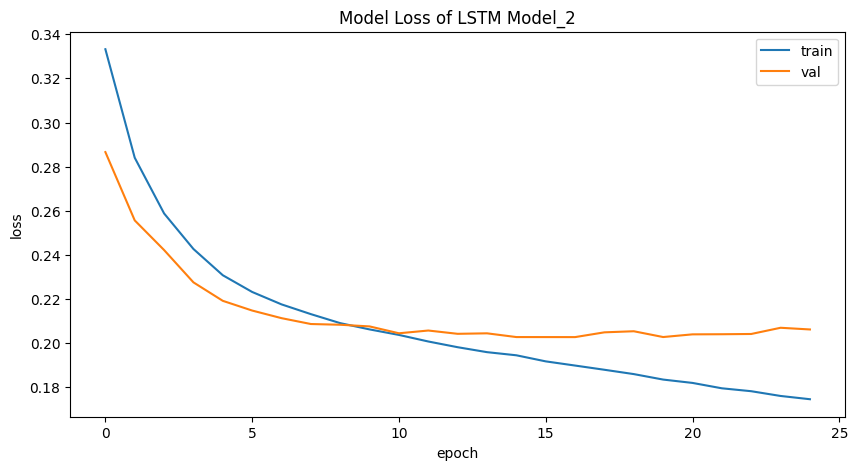

In [112]:
plt.figure(figsize=(10,5))
plt.plot(lstm_history_2.history["loss"])
plt.plot(lstm_history_2.history["val_loss"])
plt.title('Model Loss of LSTM Model_2')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

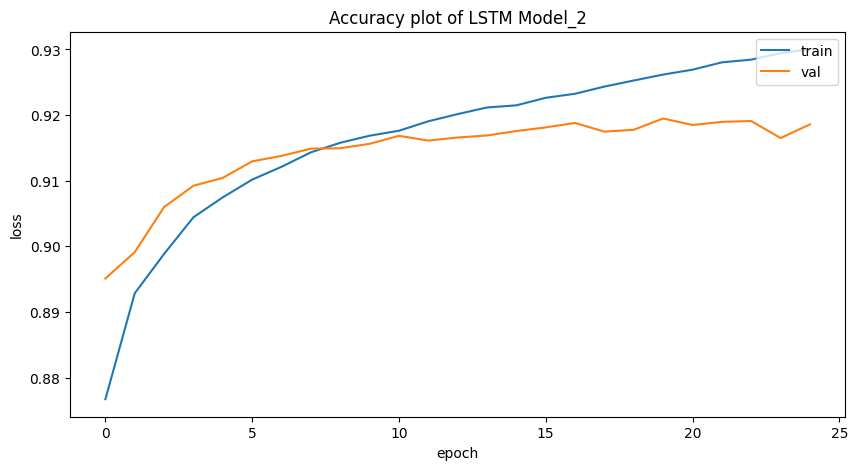

In [113]:
plt.figure(figsize=(10,5))
plt.plot(lstm_history_2.history["accuracy"])
plt.plot(lstm_history_2.history["val_accuracy"])
plt.title('Accuracy plot of LSTM Model_2')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [118]:
pred = lstm_model_2.predict([padded])
pred_round = pred.round().astype('int')

2022-09-09 19:51:30.096637: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_59884_specialized_for_sequential_1_lstm_StatefulPartitionedCall_at___inference_distributed_function_60195' and '__inference_cudnn_lstm_with_fallback_59995' both implement 'lstm_22e79196-d601-4feb-802e-cfb7db4a6e5b' but their signatures do not match.


In [119]:
print("Classification report for LSTM Model_2:")
print(classification_report(y_test, pred_round, target_names = target_names))

Classification report for LSTM Model_2:
                 precision    recall  f1-score   support

         Action       0.59      0.54      0.56       578
      Adventure       0.50      0.21      0.29       278
      Animation       0.64      0.28      0.39       155
         Comedy       0.73      0.50      0.59      1270
          Crime       0.57      0.33      0.42       343
    Documentary       0.79      0.71      0.75       595
          Drama       0.66      0.67      0.66      1653
         Family       0.68      0.32      0.43       299
        Fantasy       0.49      0.11      0.18       172
        Foreign       0.00      0.00      0.00        93
        History       0.00      0.00      0.00        93
         Horror       0.65      0.62      0.63       504
          Music       0.59      0.41      0.49       139
        Mystery       0.50      0.01      0.02       193
        Romance       0.63      0.32      0.42       542
Science Fiction       0.69      0.46      0.55 

### Predicting Genres from Movie Posters

In [47]:
# There are some terms with occurrence as low as 1
sum(image_genres['genres'].apply(lambda x: ', '.join(tag for tag in x)).value_counts()==1)

11

In [48]:
genre_cnt = pd.DataFrame(image_genres['genres'].apply(lambda x: ', '.join(tag for tag in x)).value_counts()).reset_index()
genre_cnt.columns = ['genres', 'count']

count_one_genres_image = genre_cnt[genre_cnt['count']==1]
count_one_genres_image  = count_one_genres_image.reset_index(drop=True)

unique_indexes_image = pd.DataFrame(image_genres['genres']
                                    .apply(lambda x: ', '.join(tag for tag in x))).merge(count_one_genres_image,
                                                                                          how='left',
                                                                                          on='genres')
unique_indexes_image = unique_indexes_image[unique_indexes_image['count'].notna()].index

Deleting unique genres from image array

In [49]:
poster_images = np.delete(poster_images, unique_indexes_image, axis=0)

Deleting unique genres from labels

In [50]:
image_genres = image_genres.drop(image_genres.index[unique_indexes_image]).reset_index(drop=True)

In [51]:
#Creating target data frame with MultiLabelBinarizer

binarizer_image = MultiLabelBinarizer()
y_image = binarizer_image.fit_transform(image_genres['genres'])

In [52]:
print(poster_images.shape)
print(y_image.shape)

(19582, 128, 128, 3)
(19582, 19)


In [59]:
#Train - test - splitting images

X_train_image, X_test_image, y_train_image, y_test_image = train_test_split(poster_images, 
                                                                            y_image, 
                                                                            test_size = 0.3, 
                                                                            stratify=y_image)

In [60]:
X_train_image = X_train_image/255
X_test_image = X_test_image/255

In [61]:
print(X_train_image.shape, y_train_image.shape)
print(X_test_image.shape, y_test_image.shape)

(13707, 128, 128, 3) (13707, 19)
(5875, 128, 128, 3) (5875, 19)


In [62]:
cnn_model = keras.models.Sequential()
cnn_model.add(keras.layers.Input(shape = (128, 128, 3)))
cnn_model.add(keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), activation='relu'))
cnn_model.add(keras.layers.MaxPool2D(pool_size = (2, 2)))
cnn_model.add(keras.layers.Dropout(0.5))
cnn_model.add(keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
cnn_model.add(keras.layers.MaxPool2D(pool_size = (2, 2)))
cnn_model.add(keras.layers.Dropout(0.5))
cnn_model.add(Flatten())
cnn_model.add(keras.layers.Dense(32, activation='relu'))
cnn_model.add(keras.layers.Dense(y_train_image.shape[1], activation = "sigmoid"))

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28800)             0

2022-09-09 16:09:39.535532: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-09 16:09:39.536475: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [63]:
cnn_model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

In [64]:
early_stop_cnn = keras.callbacks.EarlyStopping(monitor = "val_accuracy",
                                               patience = 2)

model_save_cnn = keras.callbacks.ModelCheckpoint("checkpoint_cnn",
                                                 monitor = "val_accuracy",
                                                 save_best_only = True,
                                                 save_weights_only = True,
                                                 mode = "max")

cnn_history = cnn_model.fit(X_train_image, y_train_image,
                            epochs = 20, verbose = 1, batch_size=256,
                            validation_data = (X_test_image, y_test_image),
                            callbacks = [early_stop_cnn, model_save_cnn])

Train on 13707 samples, validate on 5875 samples
Epoch 1/20
13707/13707 [==============================] - 1054s 77ms/sample - loss: 0.4155 - accuracy: 0.8299 - val_loss: 0.4139 - val_accuracy: 0.8833
Epoch 2/20
13707/13707 [==============================] - 1070s 78ms/sample - loss: 0.2891 - accuracy: 0.8923 - val_loss: 0.3941 - val_accuracy: 0.8922
Epoch 3/20
13707/13707 [==============================] - 1034s 75ms/sample - loss: 0.2823 - accuracy: 0.8947 - val_loss: 0.4100 - val_accuracy: 0.8929
Epoch 4/20
13707/13707 [==============================] - 1016s 74ms/sample - loss: 0.2799 - accuracy: 0.8953 - val_loss: 0.3969 - val_accuracy: 0.8937
Epoch 5/20
13707/13707 [==============================] - 1071s 78ms/sample - loss: 0.2778 - accuracy: 0.8958 - val_loss: 0.3874 - val_accuracy: 0.8932
Epoch 6/20
13707/13707 [==============================] - 1046s 76ms/sample - loss: 0.2758 - accuracy: 0.8964 - val_loss: 0.3719 - val_accuracy: 0.8934


In [65]:
cnn_model_train_eval = cnn_model.evaluate(X_train_image, y_train_image)
cnn_model_test_eval = cnn_model.evaluate(X_test_image, y_test_image)

13707/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

5875/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [67]:
print(f'Training Loss: {cnn_model_train_eval[0]}, Training Accuracy: {cnn_model_train_eval[1]}')
print(f'Test Loss: {cnn_model_test_eval[0]}, Test Accuracy: {cnn_model_test_eval[1]}')

Training Loss: 0.368902054184887, Training Accuracy: 0.8947133421897888
Test Loss: 0.3718949386464789, Test Accuracy: 0.8933572769165039


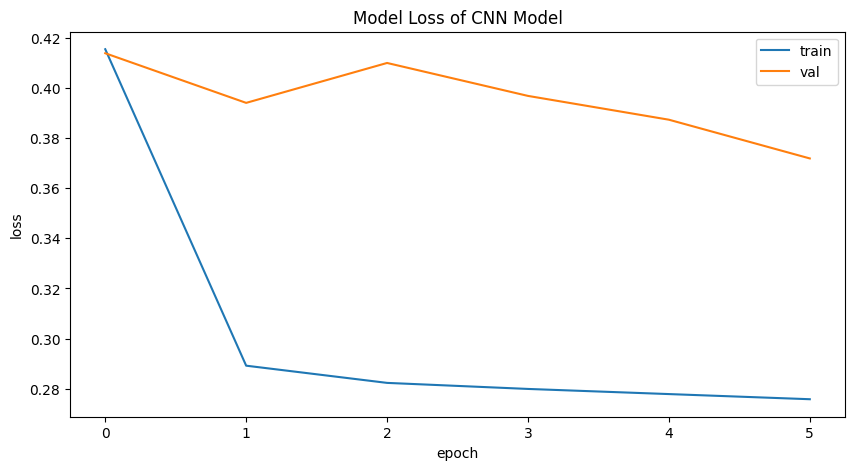

In [68]:
plt.figure(figsize=(10,5))
plt.plot(cnn_history.history["loss"])
plt.plot(cnn_history.history["val_loss"])
plt.title('Model Loss of CNN Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

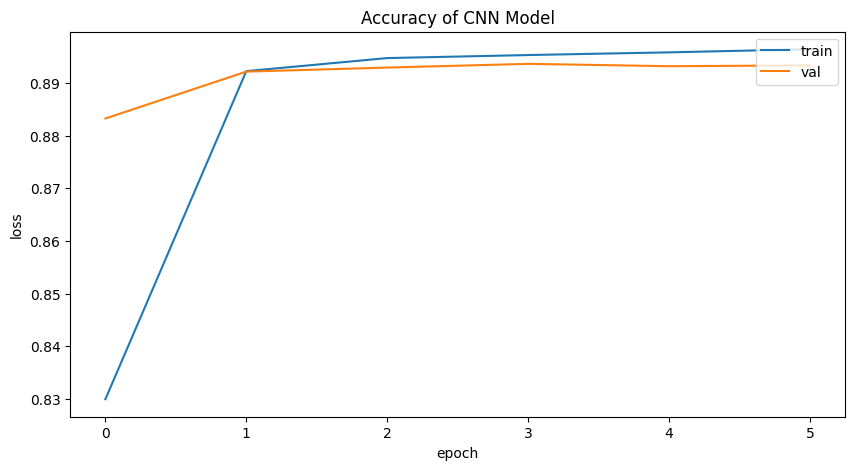

In [69]:
plt.figure(figsize=(10,5))
plt.plot(cnn_history.history["accuracy"])
plt.plot(cnn_history.history["val_accuracy"])
plt.title('Accuracy of CNN Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [78]:
predictions = cnn_model.predict(X_test_image)

In [79]:
predictions_round = predictions.round().astype('int')

In [81]:
print("Classification Report for CNN:")
print(classification_report(y_test_image, predictions_round, target_names = target_names))

Classification Report for CNN:
                 precision    recall  f1-score   support

         Action       0.00      0.00      0.00       869
      Adventure       0.00      0.00      0.00       423
      Animation       0.35      0.08      0.13       234
         Comedy       0.53      0.47      0.50      1862
          Crime       0.00      0.00      0.00       510
    Documentary       0.33      0.00      0.00       790
          Drama       0.54      0.11      0.18      2419
         Family       0.35      0.15      0.21       449
        Fantasy       0.00      0.00      0.00       261
        Foreign       0.00      0.00      0.00       137
        History       0.00      0.00      0.00       131
         Horror       0.00      0.00      0.00       749
          Music       0.00      0.00      0.00       202
        Mystery       0.00      0.00      0.00       287
        Romance       0.00      0.00      0.00       817
Science Fiction       0.00      0.00      0.00       444